In [4]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np

import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from datasets import load_dataset, load_metric
from transformers import TrainingArguments, Trainer, AutoTokenizer, AutoConfig, AutoModelForSequenceClassification, pipeline

/home/german/anaconda3/envs/compression/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


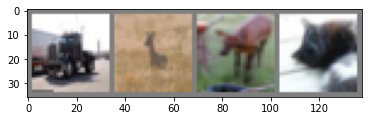

truck deer  deer  cat  


In [6]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [9]:
net = net.to(device)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [11]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.to(device))
        loss = criterion(outputs.to(device), labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}', end=" ")
            running_loss = 0.0
print('Finished Training')

[1,  2000] loss: 2.237 [1,  4000] loss: 1.888 [1,  6000] loss: 1.742 [1,  8000] loss: 1.640 [1, 10000] loss: 1.556 [1, 12000] loss: 1.479 [2,  2000] loss: 1.400 [2,  4000] loss: 1.374 [2,  6000] loss: 1.366 [2,  8000] loss: 1.316 [2, 10000] loss: 1.313 [2, 12000] loss: 1.275 [3,  2000] loss: 1.216 [3,  4000] loss: 1.204 [3,  6000] loss: 1.201 [3,  8000] loss: 1.210 [3, 10000] loss: 1.188 [3, 12000] loss: 1.156 [4,  2000] loss: 1.110 [4,  4000] loss: 1.120 [4,  6000] loss: 1.101 [4,  8000] loss: 1.111 [4, 10000] loss: 1.086 [4, 12000] loss: 1.096 [5,  2000] loss: 1.022 [5,  4000] loss: 1.035 [5,  6000] loss: 1.039 [5,  8000] loss: 1.068 [5, 10000] loss: 1.059 [5, 12000] loss: 1.037 [6,  2000] loss: 0.972 [6,  4000] loss: 0.985 [6,  6000] loss: 0.973 [6,  8000] loss: 0.992 [6, 10000] loss: 1.006 [6, 12000] loss: 0.982 [7,  2000] loss: 0.896 [7,  4000] loss: 0.909 [7,  6000] loss: 0.945 [7,  8000] loss: 0.944 [7, 10000] loss: 0.950 [7, 12000] loss: 0.960 [8,  2000] loss: 0.845 [8,  4000] 

In [12]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images.to(device))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 62 %


In [13]:
im = images[0,:,:,:].reshape(1,3,32,32).to(device)

In [14]:
%%timeit -n 10 -r 10
with torch.no_grad():
    pred = net(im)

428 µs ± 170 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


# Дистиляция

In [15]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Lightweight neural network class to be used as student:
class LightNet(nn.Module):
    def __init__(self):
        super(LightNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 60)
        self.fc2 = nn.Linear(60, 42)
        self.fc3 = nn.Linear(42, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [16]:
def train(model, trainloader, epochs, learning_rate, device):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs.to(device))
            loss = criterion(outputs.to(device), labels.to(device))
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}', end=" ")
                running_loss = 0.0

def test(model, testloader, device):
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = net(images.to(device))
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')
    
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

In [17]:
torch.manual_seed(42)
nn_deep = Net().to(device)
train(nn_deep, trainloader, epochs=10, learning_rate=0.001, device=device)
test_accuracy_deep = test(nn_deep, testloader, device)

# Instantiate the lightweight network:
torch.manual_seed(42)
nn_light = LightNet().to(device)

[1,  2000] loss: 0.742 [1,  4000] loss: 0.787 [1,  6000] loss: 0.808 [1,  8000] loss: 0.832 [1, 10000] loss: 0.838 [1, 12000] loss: 0.830 [2,  2000] loss: 0.702 [2,  4000] loss: 0.773 [2,  6000] loss: 0.765 [2,  8000] loss: 0.780 [2, 10000] loss: 0.829 [2, 12000] loss: 0.811 [3,  2000] loss: 0.717 [3,  4000] loss: 0.727 [3,  6000] loss: 0.742 [3,  8000] loss: 0.788 [3, 10000] loss: 0.789 [3, 12000] loss: 0.790 [4,  2000] loss: 0.684 [4,  4000] loss: 0.715 [4,  6000] loss: 0.745 [4,  8000] loss: 0.746 [4, 10000] loss: 0.770 [4, 12000] loss: 0.782 [5,  2000] loss: 0.670 [5,  4000] loss: 0.707 [5,  6000] loss: 0.715 [5,  8000] loss: 0.738 [5, 10000] loss: 0.763 [5, 12000] loss: 0.761 [6,  2000] loss: 0.661 [6,  4000] loss: 0.672 [6,  6000] loss: 0.699 [6,  8000] loss: 0.736 [6, 10000] loss: 0.746 [6, 12000] loss: 0.767 [7,  2000] loss: 0.632 [7,  4000] loss: 0.663 [7,  6000] loss: 0.697 [7,  8000] loss: 0.684 [7, 10000] loss: 0.751 [7, 12000] loss: 0.747 [8,  2000] loss: 0.608 [8,  4000] 

In [18]:
torch.manual_seed(42)
new_nn_light = LightNet().to(device)

In [19]:
total_params_deep = "{:,}".format(sum(p.numel() for p in nn_deep.parameters()))
print(f"Net parameters: {total_params_deep}")
total_params_light = "{:,}".format(sum(p.numel() for p in nn_light.parameters()))
print(f"LightNet parameters: {total_params_light}")

Net parameters: 62,006
LightNet parameters: 29,924


In [20]:
train(nn_light, trainloader, epochs=10, learning_rate=0.001, device=device)
test_accuracy_light_ce = test(nn_light, testloader, device)

[1,  2000] loss: 0.593 [1,  4000] loss: 0.625 [1,  6000] loss: 0.640 [1,  8000] loss: 0.694 [1, 10000] loss: 0.665 [1, 12000] loss: 0.696 [2,  2000] loss: 0.595 [2,  4000] loss: 0.624 [2,  6000] loss: 0.645 [2,  8000] loss: 0.642 [2, 10000] loss: 0.674 [2, 12000] loss: 0.700 [3,  2000] loss: 0.578 [3,  4000] loss: 0.616 [3,  6000] loss: 0.649 [3,  8000] loss: 0.634 [3, 10000] loss: 0.651 [3, 12000] loss: 0.680 [4,  2000] loss: 0.560 [4,  4000] loss: 0.600 [4,  6000] loss: 0.627 [4,  8000] loss: 0.642 [4, 10000] loss: 0.680 [4, 12000] loss: 0.680 [5,  2000] loss: 0.568 [5,  4000] loss: 0.595 [5,  6000] loss: 0.629 [5,  8000] loss: 0.651 [5, 10000] loss: 0.645 [5, 12000] loss: 0.670 [6,  2000] loss: 0.540 [6,  4000] loss: 0.590 [6,  6000] loss: 0.601 [6,  8000] loss: 0.643 [6, 10000] loss: 0.669 [6, 12000] loss: 0.647 [7,  2000] loss: 0.527 [7,  4000] loss: 0.586 [7,  6000] loss: 0.615 [7,  8000] loss: 0.633 [7, 10000] loss: 0.652 [7, 12000] loss: 0.676 [8,  2000] loss: 0.546 [8,  4000] 

In [21]:
print(f"Teacher accuracy: {test_accuracy_deep:.2f}%")
print(f"Student accuracy: {test_accuracy_light_ce:.2f}%")

Teacher accuracy: 60.61%
Student accuracy: 59.67%


In [22]:
def train_knowledge_distillation(teacher, student, trainloader, epochs, learning_rate, T, soft_target_loss_weight, ce_loss_weight, device):
    ce_loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    teacher.eval()  # Teacher set to evaluation mode
    student.train() # Student to train mode

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass with the teacher model - do not save gradients here as we do not change the teacher's weights
            with torch.no_grad():
                teacher_logits = teacher(inputs)

            # Forward pass with the student model
            student_logits = student(inputs)

            #Soften the student logits by applying softmax first and log() second
            soft_targets = nn.functional.softmax(teacher_logits / T, dim=-1)
            soft_prob = nn.functional.log_softmax(student_logits / T, dim=-1)

            # Calculate the soft targets loss. Scaled by T**2 as suggested by the authors of the paper "Distilling the knowledge in a neural network"
            soft_targets_loss = -torch.sum(soft_targets * soft_prob) / soft_prob.size()[0] * (T**2)

            # Calculate the true label loss
            label_loss = ce_loss(student_logits, labels)

            # Weighted sum of the two losses
            loss = soft_target_loss_weight * soft_targets_loss + ce_loss_weight * label_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(trainloader)}")

# Apply ``train_knowledge_distillation`` with a temperature of 2. Arbitrarily set the weights to 0.75 for CE and 0.25 for distillation loss.
train_knowledge_distillation(teacher=nn_deep, student=new_nn_light, trainloader=trainloader, epochs=10, learning_rate=0.001, T=2, soft_target_loss_weight=0.25, ce_loss_weight=0.75, device=device)
test_accuracy_light_ce_and_kd = test(new_nn_light, testloader, device)

Epoch 1/10, Loss: 3.6178487131881716
Epoch 2/10, Loss: 3.46411303024292
Epoch 3/10, Loss: 3.4041329905509947
Epoch 4/10, Loss: 3.3654312860679627
Epoch 5/10, Loss: 3.3393152357292175
Epoch 6/10, Loss: 3.319714995803833
Epoch 7/10, Loss: 3.3041077438354494
Epoch 8/10, Loss: 3.2896537271881106
Epoch 9/10, Loss: 3.281860121097565
Epoch 10/10, Loss: 3.271619061126709
Accuracy of the network on the 10000 test images: 59 %
Test Accuracy: 59.67%


In [23]:
# Compare the student test accuracy with and without the teacher, after distillati
print(f"Teacher accuracy: {test_accuracy_deep:.2f}%")
print(f"Student accuracy without teacher: {test_accuracy_light_ce:.2f}%")
print(f"Student accuracy with CE + KD: {test_accuracy_light_ce_and_kd:.2f}%")

Teacher accuracy: 60.61%
Student accuracy without teacher: 59.67%
Student accuracy with CE + KD: 59.67%


In [83]:
%%timeit -n 10 -r 10
with torch.no_grad():
    pred = new_nn_light(im)

396 µs ± 97.9 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)
